# Exercise 7: Deeper dive into `geopandas`

Skills:

* Attributes to get from `geometry`
* Buffering
* Multiple `geometry` columns
* Clipping
* Spatial joins - more discussion on `how` and `predicate` arguments
* Overlay - more discussion on `how` arguments

References:
* spatial join vs overlay [explanation](https://groups.google.com/g/geopandas/c/H_qzH2T5cCE)
* `geopandas` tutorials by package creator: https://github.com/jorisvandenbossche/geopandas-tutorial
* `geopandas` concepts, explanations, but datasets use Hebrew: https://geobgu.xyz/py/geopandas2.html
* Advanced spatial modeling concepts: https://geographicdata.science/book/notebooks/01_geo_thinking.html

In [1]:
import geopandas as gpd
import intake
import pandas as pd

FOLDER = "./data/"
FILE_NAME = "exercise_5_stops_sample.parquet"
stops=gpd.read_parquet(f"{FOLDER}{FILE_NAME}")

#catalog = intake.open_catalog(
    #"../_shared_utils/shared_utils/shared_data_catalog.yml")

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_171/1182803170.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling P

districts = catalog.caltrans_districts.read()
stops = catalog.ca_transit_stops.read()

In [2]:
districts = gpd.read_file('https://caltrans-gis.dot.ca.gov/arcgis/rest/services/CHboundary/District_Tiger_Lines/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson')

In [3]:
districts.head()

,OBJECTID,DISTRICT,Region,Shape__Area,Shape__Length,geometry
0,1,1,North,4.659910e+10,1.644579e+06,"POLYGON ((-123.51781 42.00076, -123.51793 42.0..."
1,2,2,North,1.266950e+11,1.775639e+06,"POLYGON ((-122.30409 42.00835, -122.34369 42.0..."
2,3,3,North,5.458748e+10,1.468290e+06,"POLYGON ((-121.40482 40.13005, -121.40482 40.1..."
3,4,4,,3.383387e+10,1.291122e+06,"POLYGON ((-122.38960 38.85632, -122.38980 38.8..."
4,5,5,Central,4.853090e+10,1.380598e+06,"POLYGON ((-121.21407 36.95981, -121.21906 36.9..."


In [4]:
stops.head()

,feed_key,stop_id,stop_key,stop_name,route_type_0,route_type_1,route_type_2,route_type_3,route_type_4,route_type_5,route_type_6,route_type_7,route_type_11,route_type_12,missing_route_type,geometry
0,8a47f5aa51f481e9ddc7c497bd72d264,1117,996713f17805d89de17057bcd41a482d,ANTON-SAKIOKA,NaN,NaN,NaN,55.0,NaN,NaN,None,None,None,None,None,POINT (-117.87903 33.69030)
1,8a47f5aa51f481e9ddc7c497bd72d264,2820,b7cb986ea2688781ce06c0654a08075c,GOLDEN WEST-EDINGER,NaN,NaN,NaN,21.0,NaN,NaN,None,None,None,None,None,POINT (-118.00668 33.73067)
2,180d48eb03829594478082dca5782ccd,616,e598476f943975d3657c2164506ce82c,WESTWOOD MEDICAL PLAZA,NaN,NaN,NaN,85.0,NaN,NaN,None,None,None,None,None,POINT (-118.44548 34.06552)
3,a9f08db1bc889c72499a14d329cd7260,3931421,1b6bfc950393863989b62ffa17794ca2,Sepulveda & Ohio Mid Block (Southbound),NaN,NaN,NaN,4.0,NaN,NaN,None,None,None,None,None,POINT (-118.44837 34.05220)
4,a9f08db1bc889c72499a14d329cd7260,5802520,4bbd88abc37ee43f799dc9dd8d8bb23a,6th St & Witmer St (Westbound),NaN,NaN,NaN,86.0,NaN,NaN,None,None,None,None,None,POINT (-118.26547 34.05549)


## Attributes to get from `geometry`

A lot of information is stored in the `geometry` column. 
Take a look at each of the attributes for each of the datasets.

For each gdf, look at:
* its coordinate reference system (`gdf.crs`) 
* which column is its geometry (`gdf.geometry.name`)
* for a point, get the x, y of the first row (`gdf.geometry.x`, `gdf.geometry.y`)
* for a line, get the length of the first row (`gdf.geometry.length`)
* for a polygon, get the area of the first row (`gdf.geometry.area`)
* note: the length and area must be in units that can be interpreted, such as meters, feet, miles, etc and not decimal degrees.

In [5]:
stops.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
districts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
type(stops)

geopandas.geodataframe.GeoDataFrame

In [9]:
type(districts)

geopandas.geodataframe.GeoDataFrame

In [10]:
stops.geometry.name

'geometry'

In [11]:
districts.geometry.name

'geometry'

In [22]:
districts = districts.to_crs("EPSG:2229") #unit in feet
#one_geom = districts[districts.DISTRICT==7].geometry.iloc[0]
#print(type(one_geom))
stops = stops.to_crs("EPSG:2229")

In [23]:
stops['stop_x'] = stops.geometry.x

In [24]:
stops['stop_y'] = stops.geometry.y

In [25]:
districts['districts_sq_ft'] = districts.geometry.area

In [26]:
districts['districts_ft'] = districts.geometry.length

In [27]:
stops.head()

,feed_key,stop_id,stop_key,stop_name,route_type_0,route_type_1,route_type_2,route_type_3,route_type_4,route_type_5,route_type_6,route_type_7,route_type_11,route_type_12,missing_route_type,geometry,stop_x,stop_y
0,8a47f5aa51f481e9ddc7c497bd72d264,1117,996713f17805d89de17057bcd41a482d,ANTON-SAKIOKA,NaN,NaN,NaN,55.0,NaN,NaN,None,None,None,None,None,POINT (6598469.381 1709695.341),6.598469e+06,1.709695e+06
1,8a47f5aa51f481e9ddc7c497bd72d264,2820,b7cb986ea2688781ce06c0654a08075c,GOLDEN WEST-EDINGER,NaN,NaN,NaN,21.0,NaN,NaN,None,None,None,None,None,POINT (6559635.436 1724367.377),6.559635e+06,1.724367e+06
2,180d48eb03829594478082dca5782ccd,616,e598476f943975d3657c2164506ce82c,WESTWOOD MEDICAL PLAZA,NaN,NaN,NaN,85.0,NaN,NaN,None,None,None,None,None,POINT (6426746.299 1846525.878),6.426746e+06,1.846526e+06
3,a9f08db1bc889c72499a14d329cd7260,3931421,1b6bfc950393863989b62ffa17794ca2,Sepulveda & Ohio Mid Block (Southbound),NaN,NaN,NaN,4.0,NaN,NaN,None,None,None,None,None,POINT (6425851.228 1841683.131),6.425851e+06,1.841683e+06
4,a9f08db1bc889c72499a14d329cd7260,5802520,4bbd88abc37ee43f799dc9dd8d8bb23a,6th St & Witmer St (Westbound),NaN,NaN,NaN,86.0,NaN,NaN,None,None,None,None,None,POINT (6481254.880 1842683.703),6.481255e+06,1.842684e+06


In [28]:
districts.head()

,OBJECTID,DISTRICT,Region,Shape__Area,Shape__Length,geometry,districts_sq_ft,districts_ft
0,1,1,North,4.659910e+10,1.644579e+06,"POLYGON ((5050292.349 4784444.908, 5050260.600...",2.951616e+11,4.130051e+06
1,2,2,North,1.266950e+11,1.775639e+06,"POLYGON ((5382628.905 4770985.627, 5371797.907...",7.870933e+11,4.432004e+06
2,3,3,North,5.458748e+10,1.468290e+06,"POLYGON ((5605540.574 4073307.906, 5605545.151...",3.548373e+11,3.745147e+06
3,4,4,,3.383387e+10,1.291122e+06,"POLYGON ((5308833.259 3618920.240, 5308774.452...",2.265720e+11,3.342878e+06
4,5,5,Central,4.853090e+10,1.380598e+06,"POLYGON ((5622090.455 2914919.212, 5620633.501...",3.436951e+11,3.668621e+06


districts[districts.DISTRICT==7].geometry.iloc[0]

one_geom.area

## Buffering

Typically, you want to draw some radius around a geometry. This is buffering. It is most often used for points and lines, but occasionally, you'll use it for polygons too. The result of a buffer is always a polygon. 

Examples of questions you're asking:
* how many destinations can I reach within 5 miles from my location? (my location is a point, and a 5 mile buffer should be drawn)
* how many bus stops are on this road? Well, it's highly unlikely you'll have a bus stop (point) fall exactly on the road (line) in your dataset. Instead, you can draw a small buffer (maybe 20 meters) around the road and see how many bus stops fall within it.

Draw a buffer of 50 meters around the stop and set the `geometry` column to be the buffered geometry.

gdfs can hold multiple geometry columns, and geoparquets and GeoJSONs can save files with multiple geometry columns.

In [30]:
stops = stops.to_crs("EPSG:3310") # unit in meters
stops = stops.assign(
    geometry_buffered = stops.geometry.buffer(50)
)

stops[["feed_key", "stop_id", "stop_name", 
       "geometry", "geometry_buffered"]].head(2)

,feed_key,stop_id,stop_name,geometry,geometry_buffered
0,8a47f5aa51f481e9ddc7c497bd72d264,1117,ANTON-SAKIOKA,POINT (196697.609 -478313.662),"POLYGON ((196747.609 -478313.662, 196747.368 -..."
1,8a47f5aa51f481e9ddc7c497bd72d264,2820,GOLDEN WEST-EDINGER,POINT (184766.833 -474094.408),"POLYGON ((184816.833 -474094.408, 184816.592 -..."


## Multiple `geometry` columns

By default, the `geometry` column is used. But, if you have another `geometry` column you'd like to use, you can set it.

In [71]:
feed_name = {
   "71d91d70ad6c07b1f9b0a618ffceef93": "Alhambra Schedule",
    "a7ba6f075198e9bf9152fab6c7faf0f6": "San Diego Schedule",
    "4f77ef02b983eccc0869c7540f98a7d0": "Big Blue Bus Schedule",
    "ae93a53469371fb3f9059d2097f66842": "OmniTrans Schedule",
    "180d48eb03829594478082dca5782ccd": "Culver City Schedule"
}
stops = stops.assign(
    name = stops.feed_key.map(feed_name)
)

In [72]:
keep_me = ['Alhambra Schedule', 'San Diego Schedule', 'Big Blue Bus Schedule', 'OmniTrans Schedule', 'Culver City Schedule']
stops0 = stops[stops.name.isin(keep_me)]

In [77]:
stops0.head()

,feed_key,stop_id,stop_key,stop_name,route_type_0,route_type_1,route_type_2,route_type_3,route_type_4,route_type_5,route_type_6,route_type_7,route_type_11,route_type_12,missing_route_type,geometry,stop_x,stop_y,geometry_buffered,name
2,180d48eb03829594478082dca5782ccd,616,e598476f943975d3657c2164506ce82c,WESTWOOD MEDICAL PLAZA,NaN,NaN,NaN,85.0,NaN,NaN,None,None,None,None,None,POINT (143488.120 -437722.486),6.426746e+06,1.846526e+06,"POLYGON ((143538.120 -437722.486, 143537.879 -...",Culver City Schedule
5,ae93a53469371fb3f9059d2097f66842,5407,78f87661965325e2bf5fdcf8b8ae923d,Northpark @ Serrano Wb Fs,NaN,NaN,NaN,16.0,NaN,NaN,None,None,None,None,None,POINT (246661.261 -422991.227),6.766220e+06,1.887677e+06,"POLYGON ((246711.261 -422991.227, 246711.020 -...",OmniTrans Schedule
7,a7ba6f075198e9bf9152fab6c7faf0f6,41235,3e37f2ff36e642f3c7593ed1a60b4637,Poway Rd & Pomerado Rd,NaN,NaN,NaN,28.0,NaN,NaN,None,None,None,None,None,POINT (274823.195 -558116.800),6.849006e+06,1.442192e+06,"POLYGON ((274873.195 -558116.800, 274872.954 -...",San Diego Schedule
9,4f77ef02b983eccc0869c7540f98a7d0,1557,4f03829cd225a77b989d56f1ecbd9a3a,26TH SB & WASHINGTON (SM) FS,NaN,NaN,NaN,17.0,NaN,NaN,None,None,None,None,None,POINT (140316.615 -440778.364),6.416134e+06,1.836719e+06,"POLYGON ((140366.615 -440778.364, 140366.374 -...",Big Blue Bus Schedule
10,a7ba6f075198e9bf9152fab6c7faf0f6,11367,63bc51ab5314fe5181dd7b823d750079,Imperial Av & Greenwood Cemetery,NaN,NaN,NaN,34.0,NaN,NaN,None,None,None,None,None,POINT (272093.079 -585617.476),6.838109e+06,1.352022e+06,"POLYGON ((272143.079 -585617.476, 272142.838 -...",San Diego Schedule


In [78]:
stops2 = stops0[stops0.name.str.contains("Big Blue")
].set_geometry("geometry_buffered")

print(f"stops geometry: {stops0.geometry.name}")
print(f"stops2 geometry: {stops2.geometry.name}")

stops geometry: geometry
stops2 geometry: geometry_buffered


In [75]:
stops2.head()

,feed_key,stop_id,stop_key,stop_name,route_type_0,route_type_1,route_type_2,route_type_3,route_type_4,route_type_5,route_type_6,route_type_7,route_type_11,route_type_12,missing_route_type,geometry,stop_x,stop_y,geometry_buffered,name


In [79]:
stops2.head(10).explore(tiles="CartoDB Positron")

In [81]:
stops2.head(10).set_geometry("geometry").explore(
    tiles='CartoDB Positron')

In [80]:
# you can reset the geometry column on-the-fly just for mapping
stops2.head(10).set_geometry("geometry_buffered").explore(
    tiles='CartoDB Positron')

## Dissolve

Dissolve is a way to aggregate in the geospatial world. It's a way to combine multiple rows, and their geometries, into 1 row. You can also calculate statistics in the dissolve, such as `count`, `sum`, etc. 

<AxesSubplot:>

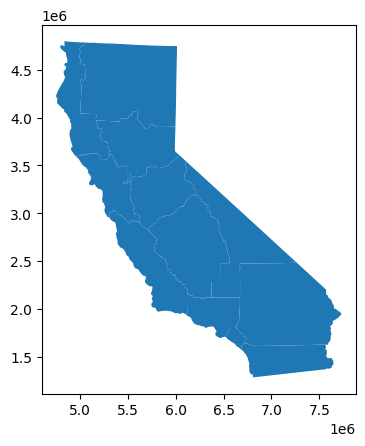

In [34]:
# There are 12 Caltrans districts
# Use dissolve to combine the 12 district polygons into 
# 1 large CA polygon 
districts.plot()

<AxesSubplot:>

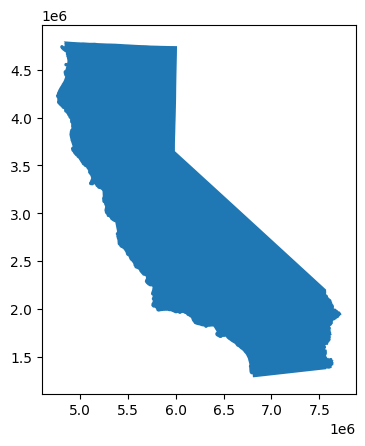

In [35]:
ca = districts.dissolve()
ca.plot()

In [36]:
ca

,geometry,OBJECTID,DISTRICT,Region,Shape__Area,Shape__Length,districts_sq_ft,districts_ft
0,"POLYGON ((6105565.229 1946214.162, 6102975.223...",1,1,North,4.659910e+10,1.644579e+06,2.951616e+11,4.130051e+06


Look at the gdf returned. Why does it say `DISTRICT==1`, yet the entire CA boundary is shown?

[Docs explanation](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html). By default, the first value is kept.

Instead, let's count how many districts there are and sum up the area.

In [37]:
districts2 = districts.assign(
    state = "CA"
) 
districts2.head(2)

,OBJECTID,DISTRICT,Region,Shape__Area,Shape__Length,geometry,districts_sq_ft,districts_ft,state
0,1,1,North,4.659910e+10,1.644579e+06,"POLYGON ((5050292.349 4784444.908, 5050260.600...",2.951616e+11,4.130051e+06,CA
1,2,2,North,1.266950e+11,1.775639e+06,"POLYGON ((5382628.905 4770985.627, 5371797.907...",7.870933e+11,4.432004e+06,CA


In [38]:
districts2[["state", "Shape__Area", "geometry"]].head(2)

,state,Shape__Area,geometry
0,CA,4.659910e+10,"POLYGON ((5050292.349 4784444.908, 5050260.600..."
1,CA,1.266950e+11,"POLYGON ((5382628.905 4770985.627, 5371797.907..."


In [39]:
ca2 = (districts2[["state", "DISTRICT", "Shape__Area", "geometry"]]
 .dissolve(
    by=["state"], 
     aggfunc={
        "DISTRICT": "count",
        "Shape__Area": "sum"})
 .reset_index()
)

ca2

,state,geometry,DISTRICT,Shape__Area
0,CA,"POLYGON ((6105565.229 1946214.162, 6102975.223...",12,6.654531e+11


<AxesSubplot:>

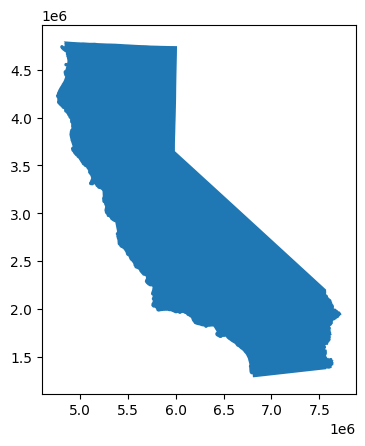

In [40]:
ca2.plot()

## Clipping

Clipping is a technique to narrow down one gdf by the boundaries of another gdf. The other gdf is called the mask. 

[Docs](https://geopandas.org/en/stable/gallery/plot_clip.html) here and [here](https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html).

Examples:
* which transit stops fall within District 7?
* find Amtrak routes within CA (cut away the lines that fall outside of CA, but keep the lines that fall within CA)

| current gdf | current geometry type | mask gdf    | 
|-------------|-----------------------|-------------|
| stops       | point                 | district    | 
| routes      | line                  | state       |


In [82]:
d7 = districts[districts.DISTRICT == 7]

In [83]:
d7 = d7.to_crs("EPSG:4326")

In [84]:
stops = stops.to_crs("EPSG:4326")

In [85]:
d7_stops = gpd.clip(stops, d7)

<AxesSubplot:>

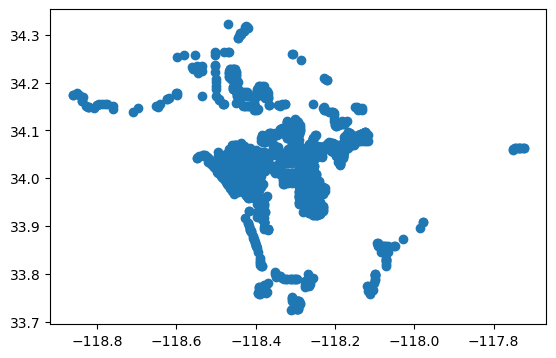

In [86]:
d7_stops.plot()

amtrak_stops = (stops0[
    #(stops.route_type.isin(['0', '1', '2'])) & ???
    (stops0.name=="Big Blue Bus Schedule")]    
    [["feed_key", "stop_id", "stop_name", "geometry"]]
    .reset_index(drop=True)
)

In [56]:
#amtrak_stops = amtrak_stops.to_crs("EPSG:4326")

In [57]:
#ca = ca.to_crs("EPSG:4326")

In [65]:
#ca_clipped = ca.clip

In [ ]:
#amtrak_stops.plot()

#astype({
    #"amtrak_stops": int})

In [89]:
stops0.to_crs("EPSG:4326").clip(
    d7.to_crs("EPSG:4326")
).explore('name')

## Spatial Join

You are asking questions about your current gdf, but require information from another gdf. A spatial join allows you to attach columns from another gdf to the current gdf.

Spatial joins do not change the **values** in the `geometry` column. The `how=` and `predicate=` arguments determine **which rows** are kept and **which geometry** column is kept. It does not change the contents of the geometry the way `gpd.overlay()` does.

* Which county does this stop belong in?
* Which bus routes run in District 7?
* Which state does this district belong in? 

| current gdf | current geometry type | another gdf | concept            |
|-------------|-----------------------|-------------|--------------------|
| stops       | point                 | county      | point-in-polygon   |
| highways    | line                  | district    | line-in-polygon    |
| districts   | polygon               | state       | polygon-in-polygon |

In [90]:
# There are 789 stops!
stops0.shape

(3177, 20)

<AxesSubplot:>

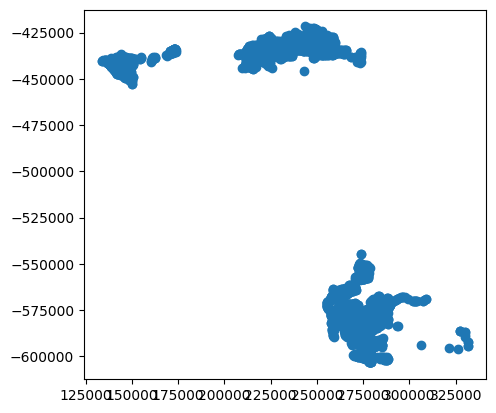

In [91]:
stops0.plot()

It looks like Amtrak stops across the US are shown.

To find which ones are located in CA, we are asking a point-in-polygon question. Which Amtrak stop (point) falls in CA (polygon)?

A spatial join can tell us this.

### Explore the various `how=` and `predicate=` arguments
* Read [docs](https://geopandas.org/en/stable/docs/user_guide/set_operations.html)
* [predicate and how explanation](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html)


#### predicate = intersects / within 
* `predicate` specifies which spatial set operation you're using. Is it a point **within** a polygon? Is it a **point** that **intersects** a polygon? 
* `intersect` is the most common predicate. 
* For lines, `intersect` and `within` can give different results. 
* A line can intersect with the polygon even if it does not fall completely within a polygon.
* For the other predicates, `contains`, `within`, `touches`, `crosses`, `overlaps`, there is a lot more nuance about how much of the interior and exterior interact. This would matter when comparing lines and polygons or polygons and polygons.

#### how = inner / left / right
* `inner`: inner join keeps only the rows of the left gdf that meets the predicate requirements (ex: point does intersect with the polygon. points that do not intersect are dropped in the resulting gdf).
* `left`:
* `right`: 

In [ ]:
# come back and check this next week!!! got the same result for 3 different joins???

In [98]:
# spatial join can tell you which stop falls into which CA or not
# make sure the CRS is the same for both gdfs
s1 = gpd.sjoin(
    stops0.to_crs("EPSG:2229"),
    ca2.to_crs("EPSG:2229"),
    how = "inner",
    predicate = "intersects"
)

s1.shape

(3177, 24)

<AxesSubplot:>

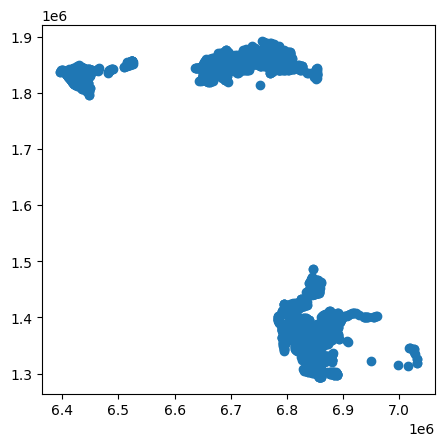

In [93]:
s1.plot()

In [96]:
# spatial join can tell you which stop falls into which CA or not
# if we do left join, then we keep all the points even if they
# do not intersect with CA
s2 = gpd.sjoin(
    stops0.to_crs("EPSG:2229"),
    ca2.to_crs("EPSG:2229"),
    how = "left",
    predicate = "intersects"
)

s2.shape

(3177, 24)

In [100]:
# Columns that do not intersect with CA are not populated for 
# `state` and `DISTRICT` and hold missing values
# but columns that do intersect with CA hold non-missing values
s2.tail()

,feed_key,stop_id,stop_key,stop_name,route_type_0,route_type_1,route_type_2,route_type_3,route_type_4,route_type_5,...,missing_route_type,geometry,stop_x,stop_y,geometry_buffered,name,index_right,state,DISTRICT,Shape__Area
6415,71d91d70ad6c07b1f9b0a618ffceef93,2619813,3db0cc8513bcf4c61863b641edf04bc3,Main St & 2nd Ave,NaN,NaN,NaN,33.0,NaN,NaN,...,None,POINT (6522535.076 1856674.959),6.522535e+06,1.856675e+06,"POLYGON ((172661.587 -434018.649, 172661.346 -...",Alhambra Schedule,0,CA,12,6.654531e+11
6416,ae93a53469371fb3f9059d2097f66842,5425,ab953429bcc701a516ca3183848f3b5a,Kendall @ Deerfield Eb Ns,NaN,NaN,NaN,16.0,NaN,NaN,...,None,POINT (6761813.290 1888423.403),6.761813e+06,1.888423e+06,"POLYGON ((245363.795 -422792.656, 245363.554 -...",OmniTrans Schedule,0,CA,12,6.654531e+11
6419,ae93a53469371fb3f9059d2097f66842,8743,8d9d24d304cab28d4dd958b9201ba28e,Highland @ State Eb Fs,NaN,NaN,NaN,17.0,NaN,NaN,...,None,POINT (6762846.543 1872546.663),6.762847e+06,1.872547e+06,"POLYGON ((245782.646 -427624.836, 245782.406 -...",OmniTrans Schedule,0,CA,12,6.654531e+11
6420,a7ba6f075198e9bf9152fab6c7faf0f6,77784,7fe724a986664894b442a636da53bac9,UCSD Health La Jolla Station,72.0,NaN,NaN,NaN,NaN,NaN,...,None,POINT (6800168.785 1416333.231),6.800169e+06,1.416333e+06,"POLYGON ((260149.777 -566306.086, 260149.536 -...",San Diego Schedule,0,CA,12,6.654531e+11
6423,71d91d70ad6c07b1f9b0a618ffceef93,2619870,b36ea3b650031d794d9e253bd29bb614,Paseo Rancho Castilla & Campus Rd,NaN,NaN,NaN,17.0,NaN,NaN,...,None,POINT (6509388.287 1846139.310),6.509388e+06,1.846139e+06,"POLYGON ((168723.033 -437313.642, 168722.793 -...",Alhambra Schedule,0,CA,12,6.654531e+11


<AxesSubplot:>

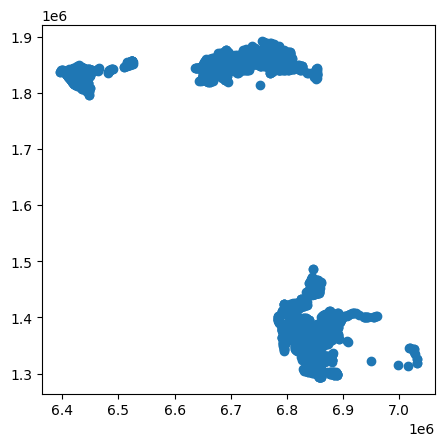

In [99]:
s2.plot()

In [103]:
# A right join is used if you want to keep only the inner join rows 
# (stops that intersect with CA)
# but use the geometry from the right

s3 = gpd.sjoin(
    ca2.to_crs("EPSG:2229"),
    stops0.to_crs("EPSG:2229"),
    how = "right",
    predicate = "intersects"
)

s3.shape

(3177, 24)

<AxesSubplot:>

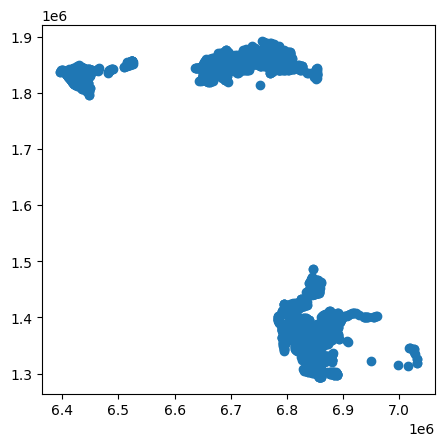

In [104]:
s3.plot()

## Overlay

**Recall**

Spatial joins do not change the **values** in the `geometry` column. The `how=` and `predicate=` arguments determine **which rows** are kept and **which geometry** column is kept. It does not change the contents of the geometry the way `gpd.overlay()` does.

Overlays **change the values** in the `geometry` column.

Polygons are the easiest to demonstrate these concepts, but typically, `overlay` can be used with lines or polygons.

#### how = intersection / symmetric difference / difference / identity
* `intersection` is the most common.
* `difference` might be of interest. 
* `symmetric_difference` is rare. This removes the middle intersection in the Venn Diagram.
* `identity` is rare.
* Look carefully at what columns are kept. If there are columns that aren't necessary, remove those columns.

,state,DISTRICT_1,Shape__Area_1,OBJECTID,DISTRICT_2,Region,Shape__Area_2,Shape__Length,districts_sq_ft,districts_ft,geometry
0,CA,12,6.654531e+11,10,7,,2.358705e+10,714383.949603,1.725326e+11,1.932635e+06,"POLYGON ((-118.12994 33.69659, -118.15581 33.6..."


<AxesSubplot:>

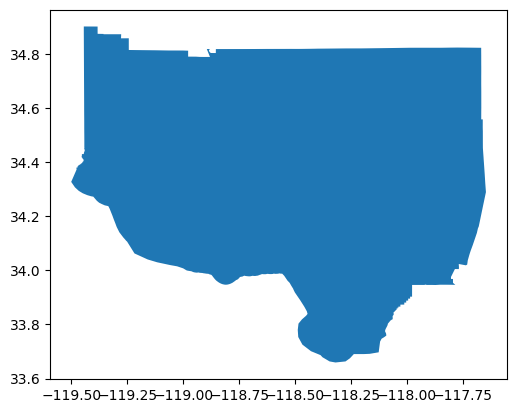

In [106]:
# d7 = districts[districts.DISTRICT==7]
d7 = d7.to_crs("EPSG:4326")
ca2 = ca2.to_crs("EPSG:4326")
intersection_overlay = gpd.overlay(
    ca2,
    d7,
    how = "intersection", 
    keep_geom_type=True
)

display(intersection_overlay)
intersection_overlay.plot()

,state,DISTRICT_1,Shape__Area,DISTRICT_2,geometry
0,CA,12,6.654531e+11,7,"POLYGON ((-118.12994 33.69659, -118.15581 33.6..."


<AxesSubplot:>

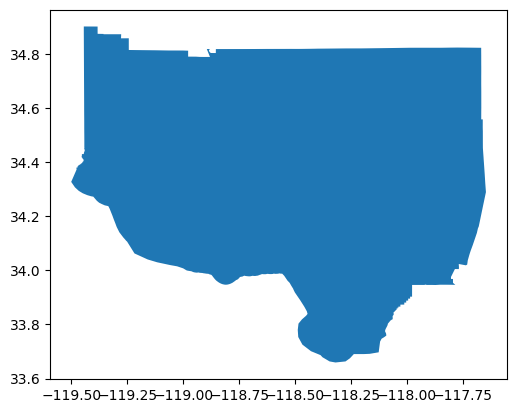

In [107]:
intersection_overlay2 = gpd.overlay(
    ca2,
    d7[["DISTRICT", "geometry"]],
    how = "intersection",
    keep_geom_type=True
)

display(intersection_overlay2)
intersection_overlay2.plot()

In [108]:
print(f"area before overlay: {ca.geometry.iloc[0].area}")
print(f"area after overlay: {intersection_overlay2.geometry.iloc[0].area}")

area before overlay: 42.65204558428103
area after overlay: 1.5710623600168427


,state,geometry,DISTRICT,Shape__Area
0,CA,"POLYGON ((-119.51948 34.33607, -119.52292 34.3...",12,6.654531e+11


<AxesSubplot:>

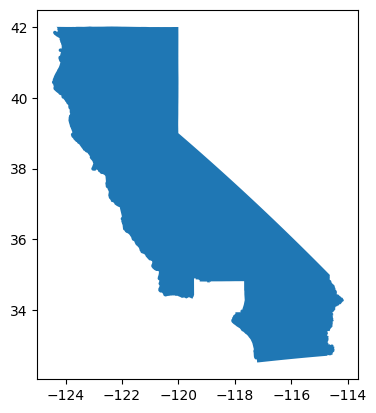

In [109]:
difference_overlay = gpd.overlay(
    ca2,
    d7[["DISTRICT", "geometry"]],
    how = "difference",
    keep_geom_type=True
)

display(difference_overlay)
difference_overlay.plot()

,DISTRICT,geometry
0,7,"POLYGON ((-117.98535 33.89555, -117.98534 33.8..."


<AxesSubplot:>

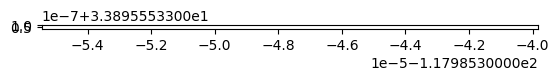

In [110]:
# From D7 polygon, remove the part that is CA..
# this is why it's plotting basically nothing
difference_overlay2 = gpd.overlay(
    d7[["DISTRICT", "geometry"]],
    ca2,
    how = "difference",
    keep_geom_type=True
)

display(difference_overlay2)
difference_overlay2.plot()